In [14]:
import pandas as pd
import numpy as np
import re
import matplotlib as plt
from wordcloud import WordCloud
from tqdm.autonotebook import tqdm
tqdm.pandas()

# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('finale_go_clean.csv')

In [3]:
df.head()

,Unnamed: 0,id,date,time,timezone,username,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,quote_url,video,lang
0,351,1.045203e+18,2018-09-27,06:47:22,UTC,10mgp,I sure will be Lucy. Couldn’t miss it after se...,"['lucylucyprior', 'xrailgroup', 'transcityrail']",1.0,1.0,3.0,NaN,NaN,0.0,1.0
1,352,1.036687e+18,2018-09-03,18:48:27,UTC,10mgp,.@DarbaarbyAbdul Hi there. Have you guys close...,['darbaarbyabdul'],0.0,0.0,0.0,NaN,NaN,0.0,1.0
2,353,1.028857e+18,2018-08-13,04:15:16,UTC,10mgp,@British_Airways We are here for your safety a...,"['johnmsv', 'emirates', 'british_airways']",1.0,0.0,0.0,NaN,NaN,0.0,1.0
3,355,1.017129e+18,2018-07-11,19:30:04,UTC,10mgp,I've just entered #AutoTraderGoals for the cha...,NaN,0.0,0.0,0.0,['#autotradergoals'],NaN,0.0,1.0
4,356,1.013736e+18,2018-07-02,10:45:58,UTC,10mgp,Hi Becci I have sent you a DM of the ongoing i...,['landrover_uk'],0.0,0.0,0.0,NaN,NaN,0.0,1.0


Check the number of usernames

In [7]:
df.username.nunique()

429

drop unneccisary columns

In [8]:
df = df.drop(['Unnamed: 0', 'timezone', 'replies_count', 'retweets_count', 'likes_count', 'quote_url', 'video', 'lang'], axis = 1)

In [11]:
df[['tweet']][226:227]

,tweet
226,#dubai #SuperCars


# Pre-Processing

Removing URLs

In [10]:
df['tweet'] = df['tweet'].progress_apply(lambda x: re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(pic.twitter.com\S+))','',x))
df['tweet'].head()

0    I sure will be Lucy. Couldn’t miss it after se...
1    .@DarbaarbyAbdul Hi there. Have you guys close...
2    @British_Airways We are here for your safety a...
3    I've just entered #AutoTraderGoals for the cha...
4    Hi Becci I have sent you a DM of the ongoing i...
Name: tweet, dtype: object

## Manually Cleaning the Tweets

1- Make all tweets lower case

In [12]:
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['tweet'].head()

0    i sure will be lucy. couldn’t miss it after se...
1    .@darbaarbyabdul hi there. have you guys close...
2    @british_airways we are here for your safety a...
3    i've just entered #autotradergoals for the cha...
4    hi becci i have sent you a dm of the ongoing i...
Name: tweet, dtype: object

2- Getting rid of punctuation

In [13]:
df['tweet'] = df['tweet'].str.replace('[^\w\s]','')
df['tweet'].head()

0    i sure will be lucy couldnt miss it after seei...
1    darbaarbyabdul hi there have you guys closed d...
2    british_airways we are here for your safety an...
3    ive just entered autotradergoals for the chanc...
4    hi becci i have sent you a dm of the ongoing i...
Name: tweet, dtype: object

2- Getting rid of stopwords

In [15]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/LujFel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['tweet'].head()

0    sure lucy couldnt miss seeing speaking line lo...
1    darbaarbyabdul hi guys closed trying phone guy...
2               british_airways safety lucky serve tea
3      ive entered autotradergoals chance win free car
4                 hi becci sent dm ongoing issue thank
Name: tweet, dtype: object

?? - Getting rid of low frequency words

In [11]:
# freq = pd.DataFrame(pd.Series(' '.join(df['tweet']).split()).value_counts(), columns=['word'])
# low_freq = freq[freq['word'] < 3]

In [12]:
# low_freq = list(low_freq.index)
# df['tweet'] = df['tweet'].progress_apply(lambda x: " ".join(x for x in x.split() if x not in low_freq))
# df['tweet'].head()

Note, I first tried the above, however as I realized I would be doing Topic modleing and stemming, I should not get rid of low freq words as they might fit in a model or would be grouped with other words after stemming

4- Spelling Correction (Takes too long!!, might need to find a quicker method)

In [13]:
# from textblob import TextBlob
# df['tweet'].progress_apply(lambda x: str(TextBlob(x).correct()))

5- Remove Special characters, numbers, punctuations

In [17]:
df['tweet'] = df['tweet'].str.replace("[^a-zA-Z#]", " ")

In [18]:
df['tweet'].head()

0    sure lucy couldnt miss seeing speaking line lo...
1    darbaarbyabdul hi guys closed trying phone guy...
2               british airways safety lucky serve tea
3      ive entered autotradergoals chance win free car
4                 hi becci sent dm ongoing issue thank
Name: tweet, dtype: object

In [19]:
df.head()

,id,date,time,username,tweet,mentions,hashtags
0,1.045203e+18,2018-09-27,06:47:22,10mgp,sure lucy couldnt miss seeing speaking line lo...,"['lucylucyprior', 'xrailgroup', 'transcityrail']",NaN
1,1.036687e+18,2018-09-03,18:48:27,10mgp,darbaarbyabdul hi guys closed trying phone guy...,['darbaarbyabdul'],NaN
2,1.028857e+18,2018-08-13,04:15:16,10mgp,british airways safety lucky serve tea,"['johnmsv', 'emirates', 'british_airways']",NaN
3,1.017129e+18,2018-07-11,19:30:04,10mgp,ive entered autotradergoals chance win free car,NaN,['#autotradergoals']
4,1.013736e+18,2018-07-02,10:45:58,10mgp,hi becci sent dm ongoing issue thank,['landrover_uk'],NaN


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376949 entries, 0 to 376948
Data columns (total 7 columns):
id          376949 non-null float64
date        376949 non-null object
time        376949 non-null object
username    376949 non-null object
tweet       376949 non-null object
mentions    164573 non-null object
hashtags    96640 non-null object
dtypes: float64(1), object(6)
memory usage: 20.1+ MB


In [20]:
# from nltk.stem.porter import *
# stemmer = PorterStemmer()

# tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
# tokenized_tweet.head()

In [21]:
af = df.groupby('username')['tweet'].progress_apply(list)
af = pd.DataFrame(af)
bf = df.groupby('username')['hashtags'].progress_apply(list)
bf = pd.DataFrame(bf)

In [22]:
bf.head()

,hashtags
username,
10mgp,"[nan, nan, nan, ['#autotradergoals'], nan, ['#..."
1_off,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3en_al3rab,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4misss,"[nan, nan, nan, ['#oscar'], ['#welldeserved'],..."
7yhy,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [23]:
af.tweet = af.tweet.apply(lambda x: ' '.join(x))

In [24]:
af.head()

,tweet
username,
10mgp,sure lucy couldnt miss seeing speaking line lo...
1_off,dont let cost dispute seoul undermine us strat...
3en_al3rab,dralsadoon dralsadoon dralsadoon dralsadoon d...
4misss,driven one long think punished forgiven way he...
7yhy,statement royal court anti corruption committe...


In [25]:
af.info()

<class 'pandas.core.frame.DataFrame'>
Index: 429 entries, 10mgp to zoetic_
Data columns (total 1 columns):
tweet    429 non-null object
dtypes: object(1)
memory usage: 6.7+ KB


In [27]:
ff = df

In [28]:
ff.head()

,id,date,time,username,tweet,mentions,hashtags
0,1.045203e+18,2018-09-27,06:47:22,10mgp,sure lucy couldnt miss seeing speaking line lo...,"['lucylucyprior', 'xrailgroup', 'transcityrail']",NaN
1,1.036687e+18,2018-09-03,18:48:27,10mgp,darbaarbyabdul hi guys closed trying phone guy...,['darbaarbyabdul'],NaN
2,1.028857e+18,2018-08-13,04:15:16,10mgp,british airways safety lucky serve tea,"['johnmsv', 'emirates', 'british_airways']",NaN
3,1.017129e+18,2018-07-11,19:30:04,10mgp,ive entered autotradergoals chance win free car,NaN,['#autotradergoals']
4,1.013736e+18,2018-07-02,10:45:58,10mgp,hi becci sent dm ongoing issue thank,['landrover_uk'],NaN


In [29]:
tokenizer = RegexpTokenizer(r'\w+')
af['tweet'] = af['tweet'].progress_apply(lambda x: tokenizer.tokenize(x))
af['tweet'].head()

username
10mgp         [sure, lucy, couldnt, miss, seeing, speaking, ...
1_off         [dont, let, cost, dispute, seoul, undermine, u...
3en_al3rab    [dralsadoon, dralsadoon, dralsadoon, dralsadoo...
4misss        [driven, one, long, think, punished, forgiven,...
7yhy          [statement, royal, court, anti, corruption, co...
Name: tweet, dtype: object

In [30]:
ff['tweet'] = ff['tweet'].progress_apply(lambda x: tokenizer.tokenize(x))
ff['tweet'].head()

0    [sure, lucy, couldnt, miss, seeing, speaking, ...
1    [darbaarbyabdul, hi, guys, closed, trying, pho...
2        [british, airways, safety, lucky, serve, tea]
3    [ive, entered, autotradergoals, chance, win, f...
4         [hi, becci, sent, dm, ongoing, issue, thank]
Name: tweet, dtype: object

In [31]:
af['tweet'][0]

['sure',
 'lucy',
 'couldnt',
 'miss',
 'seeing',
 'speaking',
 'line',
 'look',
 'forward',
 'darbaarbyabdul',
 'hi',
 'guys',
 'closed',
 'trying',
 'phone',
 'guys',
 'reservation',
 'last',
 'days',
 'phone',
 'forever',
 'engaged',
 'british',
 'airways',
 'safety',
 'lucky',
 'serve',
 'tea',
 'ive',
 'entered',
 'autotradergoals',
 'chance',
 'win',
 'free',
 'car',
 'hi',
 'becci',
 'sent',
 'dm',
 'ongoing',
 'issue',
 'thank',
 'super',
 'disappointed',
 'landrover',
 'uk',
 'landrover',
 'grange',
 'woodford',
 'waited',
 'months',
 'software',
 'fix',
 'collected',
 'still',
 'fixed',
 'days',
 'nice',
 'people',
 'service',
 'ridiculous',
 'time',
 'sell',
 'velar',
 'back',
 'good',
 'trusted',
 'mercedesbenz',
 'sorryileft',
 'beautiful',
 'enjoy',
 'good',
 'morning',
 'london',
 'heathrowairport',
 'place',
 'like',
 'home',
 'lucylucyprior',
 'congratulations',
 'lucy',
 'well',
 'deserved',
 'hope',
 'making',
 'altitudecentre',
 'real',
 'get',
 'money',
 'never',
 

Lemma

In [32]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to /Users/LujFel/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [35]:
ff['tweet'] = ff['tweet'].progress_apply(lambda x: [get_lemma2(a) for a in x])
ff['tweet'].head()

0    [sure, lucy, couldnt, miss, seeing, speaking, ...
1    [darbaarbyabdul, hi, guy, closed, trying, phon...
2         [british, airway, safety, lucky, serve, tea]
3    [ive, entered, autotradergoals, chance, win, f...
4         [hi, becci, sent, dm, ongoing, issue, thank]
Name: tweet, dtype: object

In [37]:
af['tweet'] = af['tweet'].progress_apply(lambda x: [get_lemma2(a) for a in x])
af['tweet'].head()

username
10mgp         [sure, lucy, couldnt, miss, seeing, speaking, ...
1_off         [dont, let, cost, dispute, seoul, undermine, u...
3en_al3rab    [dralsadoon, dralsadoon, dralsadoon, dralsadoo...
4misss        [driven, one, long, think, punished, forgiven,...
7yhy          [statement, royal, court, anti, corruption, co...
Name: tweet, dtype: object

In [36]:
ff['tweet'][0]

['sure',
 'lucy',
 'couldnt',
 'miss',
 'seeing',
 'speaking',
 'line',
 'look',
 'forward']

# Topic Modeling

In [35]:
ff.head()

,id,username,tweet,mentions,hashtags
0,1.045203e+18,10mgp,"[sure, lucy, couldnt, miss, seeing, speaking, ...","['lucylucyprior', 'xrailgroup', 'transcityrail']",NaN
1,1.036687e+18,10mgp,"[darbaarbyabdul, hi, guys, closed, trying, pho...",['darbaarbyabdul'],NaN
2,1.028857e+18,10mgp,"[british, airways, safety, lucky, serve, tea]","['johnmsv', 'emirates', 'british_airways']",NaN
3,1.017129e+18,10mgp,"[ive, entered, autotradergoals, chance, win, f...",NaN,['#autotradergoals']
4,1.013736e+18,10mgp,"[hi, becci, sent, dm, ongoing, issue, thank]",['landrover_uk'],NaN


In [45]:
from gensim import corpora, models
import pyLDAvis.gensim

In [46]:
pyLDAvis.enable_notebook()

In [38]:
#creating a dictionary from the data
dictionaryf = corpora.Dictionary(ff.tweet.values)
#convert to bag-of-words corpus
corpusf = [dictionaryf.doc2bow(text) for text in ff.tweet.values]
len(corpusf[0])

9

In [40]:
ldamodelf = models.ldamodel.LdaModel(corpusf,
                                    id2word = dictionaryf, # connect each word to its "spot" in the dictionary
                                    num_topics = 10, # hyperparameter T for number of topics
                                    passes = 5, # similar to epochs, how many times do we iterate through the data untel convergence accures
                                    minimum_probability = 0.01) # only including topics that meet some probability threshold

In [41]:
pyLDAvis.gensim.prepare(ldamodelf, corpusf, dictionaryf)

/Users/LujFel/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.062168  0.297549       1        1  13.688430
4     -0.226875  0.082607       2        1  13.114616
1      0.214123  0.057116       3        1  11.398359
5     -0.086883  0.126406       4        1  10.562891
0     -0.230011 -0.096478       5        1   9.913119
2      0.212918  0.026536       6        1   9.732095
3     -0.089549 -0.043010       7        1   8.420831
6     -0.136467 -0.085047       8        1   8.349963
9      0.192677 -0.116051       9        1   7.411401
8      0.087899 -0.249628      10        1   7.408293, topic_info=      Category          Freq      Term         Total  loglift  logprob
term                                                                  
1179   Default  47613.000000       via  47613.000000  30.0000  30.0000
686    Default  25352.000000     saudi  25352.000000  29.0000  29.0000
11596  Default  17740.000000     zawya  17740.000000  28.0000  28.0000
115    Default  21202.000000       one  21202.000000  27.0000  27.0000
50     Default  13639.000000    people  13639.000000  26.0000  26.0000
44     Default  11589.000000      good  11589.000000  25.0000  25.0000
389    Default  12393.000000      dont  12393.000000  24.0000  24.0000
246    Default  14041.000000        im  14041.000000  23.0000  23.0000
3115   Default   9038.000000        rt   9038.000000  22.0000  22.0000
122    Default   7785.000000       day   7785.000000  21.0000  21.0000
1385   Default   8871.000000       oil   8871.000000  20.0000  20.0000
3634   Default   8548.000000      iran   8548.000000  19.0000  19.0000
79     Default  11082.000000       get  11082.000000  18.0000  18.0000
192    Default  11224.000000     today  11224.000000  17.0000  17.0000
577    Default   9330.000000       uae   9330.000000  16.0000  16.0000
390    Default   9921.000000      know   9921.000000  15.0000  15.0000
149    Default  15620.000000        us  15620.000000  14.0000  14.0000
1669   Default   6131.000000    arabia   6131.000000  13.0000  13.0000
3200   Default   6073.000000     qatar   6073.000000  12.0000  12.0000
723    Default   6886.000000      love   6886.000000  11.0000  11.0000
234    Default   5722.000000    person   5722.000000  10.0000  10.0000
855    Default   6504.000000         u   6504.000000   9.0000   9.0000
38     Default   5228.000000     thank   5228.000000   8.0000   8.0000
93     Default   5222.000000      work   5222.000000   7.0000   7.0000
68     Default  10737.000000      like  10737.000000   6.0000   6.0000
368    Default   6027.000000      want   6027.000000   5.0000   5.0000
39     Default   5848.000000      back   5848.000000   4.0000   4.0000
396    Default  15787.000000       new  15787.000000   3.0000   3.0000
1134   Default   7462.000000      says   7462.000000   2.0000   2.0000
146    Default   7665.000000     think   7665.000000   1.0000   1.0000
...        ...           ...       ...           ...      ...      ...
1276   Topic10   2799.315186      food   2800.355957   2.6022  -4.4574
1525   Topic10   2530.609131      give   2531.649902   2.6022  -4.5583
1099   Topic10   2408.735840      live   2409.776611   2.6021  -4.6076
1944   Topic10   2165.218994      less   2166.259766   2.6021  -4.7142
5089   Topic10   2009.547974    kuwait   2010.588745   2.6021  -4.7888
4011   Topic10   1687.303345      past   1688.344116   2.6020  -4.9636
1392   Topic10   1572.912720      jobs   1573.953491   2.6019  -5.0338
517    Topic10   1485.337158       abu   1486.377808   2.6019  -5.0911
1003   Topic10   1402.443726    speech   1403.484497   2.6018  -5.1485
17449  Topic10   1392.724365     allah   1393.765991   2.6018  -5.1555
983    Topic10   1322.677856  although   1323.718872   2.6018  -5.2071
136    Topic10   1309.902100     hours   1310.942749   2.6018  -5.2168
12098  Topic10   1203.998535    lyrics   1205.039795   2.6017  -5.3011
187    Topic10   1195.159790     ready   11

In [42]:
#creating a dictionary from the data
dictionary = corpora.Dictionary(af.tweet.values)

In [43]:
#convert to bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in af.tweet.values]

In [44]:
len(corpus[0])

1174

In [45]:
ldamodel = models.ldamodel.LdaModel(corpus,
                                    id2word = dictionary, # connect each word to its "spot" in the dictionary
                                    num_topics = 10, # hyperparameter T for number of topics
                                    passes = 5, # similar to epochs, how many times do we iterate through the data untel convergence accures
                                    minimum_probability = 0.01) # only including topics that meet some probability threshold

In [46]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/LujFel/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.073831  0.063434       1        1  25.478767
5      0.069946 -0.015666       2        1  21.009098
0     -0.006376 -0.077046       3        1  20.137970
3      0.020581 -0.042582       4        1  11.615155
4      0.036302 -0.079456       5        1   7.732827
9      0.041774  0.056099       6        1   5.924762
6     -0.047792  0.065526       7        1   2.827549
7     -0.123811 -0.014964       8        1   2.007982
1     -0.033634  0.002240       9        1   1.765950
8     -0.030821  0.042414      10        1   1.499935, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
6038   Default  28226.000000            via  28226.000000  30.0000  30.0000
701    Default  15723.000000            one  15723.000000  29.0000  29.0000
873    Default  17309.000000          saudi  17309.000000  28.0000  28.0000
11866  Default   3877.000000        checked   3877.000000  27.0000  27.0000
738    Default  11519.000000         people  11519.000000  26.0000  26.0000
17714  Default   3750.000000  automatically   3750.000000  25.0000  25.0000
1076   Default   6657.000000              u   6657.000000  24.0000  24.0000
33179  Default   5185.000000           oott   5185.000000  23.0000  23.0000
741    Default   4396.000000         person   4396.000000  22.0000  22.0000
4311   Default   8328.000000            oil   8328.000000  21.0000  21.0000
570    Default   6517.000000           love   6517.000000  20.0000  20.0000
2937   Default   3477.000000       followed   3477.000000  19.0000  19.0000
516    Default   7565.000000           know   7565.000000  18.0000  18.0000
1156   Default   8066.000000          would   8066.000000  17.0000  17.0000
6297   Default   3156.000000        youtube   3156.000000  16.0000  16.0000
1041   Default   6686.000000          today   6686.000000  15.0000  15.0000
678    Default  13728.000000            new  13728.000000  14.0000  14.0000
1108   Default   3405.000000          video   3405.000000  13.0000  13.0000
17820  Default   2427.000000     unfollowed   2427.000000  12.0000  12.0000
4323   Default   3746.000000           opec   3746.000000  11.0000  11.0000
1814   Default   3333.000000              c   3333.000000  10.0000  10.0000
153    Default   2864.000000          check   2864.000000   9.0000   9.0000
361    Default   2922.000000           free   2922.000000   8.0000   8.0000
211    Default   1746.000000          daily   1746.000000   7.0000   7.0000
385    Default  10314.000000           good  10314.000000   6.0000   6.0000
1048   Default   2975.000000            top   2975.000000   5.0000   5.0000
14011  Default   2249.000000             ur   2249.000000   4.0000   4.0000
1093   Default  13043.000000             us  13043.000000   3.0000   3.0000
6877   Default   1538.000000        stories   1538.000000   2.0000   2.0000
2936   Default   2945.000000         follow   2945.000000   1.0000   1.0000
...        ...           ...            ...           ...      ...      ...
7486   Topic10     35.488548        bedroom     55.623878   3.7503  -7.2288
1897   Topic10    135.280090        century    449.578491   2.9988  -5.8906
35405  Topic10     55.878387             bh    122.069809   3.4183  -6.7748
7440   Topic10    251.264145        bahrain   2178.930664   2.0397  -5.2715
1885   Topic10     65.499908            cbs    219.025223   2.9926  -6.6159
13133  Topic10     57.605785     nowplaying    222.393234   2.8489  -6.7443
7150   Topic10    118.221466             al   2749.413330   1.0532  -6.0254
1605   Topic10     81.232910            bin   1150.052856   1.5495  -6.4006
701    Topic10    177.990417            one  15723.415039  -0.2814  -5.6162
6877   Topic10     87.234955        stories   1538.038330   1.3301  -6.3294
1093   Topic10    151.377121             

Try Stemming and more cleaning

Removing short words (less than 3 char)

In [38]:
af['tweet'] = af['tweet'].progress_apply(lambda x: [ w for w in x if len(w) > 2])

In [39]:
af.head()

,tweet
username,
10mgp,"[sure, lucy, couldnt, miss, seeing, speaking, ..."
1_off,"[dont, let, cost, dispute, seoul, undermine, s..."
3en_al3rab,"[dralsadoon, dralsadoon, dralsadoon, dralsadoo..."
4misss,"[driven, one, long, think, punished, forgiven,..."
7yhy,"[statement, royal, court, anti, corruption, co..."


In [40]:
ff['tweet'] = ff['tweet'].progress_apply(lambda x: [ w for w in x if len(w) > 2])

STEMMING!!

In [41]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

In [42]:
af['tweet'] = af['tweet'].progress_apply(lambda x: [porter_stemmer.stem(word) for word in x])
af['tweet'].head()

username
10mgp         [sure, luci, couldnt, miss, see, speak, line, ...
1_off         [dont, let, cost, disput, seoul, undermin, str...
3en_al3rab    [dralsadoon, dralsadoon, dralsadoon, dralsadoo...
4misss        [driven, one, long, think, punish, forgiven, w...
7yhy          [statement, royal, court, anti, corrupt, commi...
Name: tweet, dtype: object

In [43]:
ff['tweet'] = ff['tweet'].progress_apply(lambda x: [porter_stemmer.stem(word) for word in x])
ff['tweet'].head()

0    [sure, luci, couldnt, miss, see, speak, line, ...
1    [darbaarbyabdul, guy, close, tri, phone, guy, ...
2          [british, airway, safeti, lucki, serv, tea]
3    [ive, enter, autotradergo, chanc, win, free, car]
4                     [becci, sent, ongo, issu, thank]
Name: tweet, dtype: object

Try the model again

In [47]:
dictionaryf = corpora.Dictionary(ff.tweet.values)
corpusf = [dictionaryf.doc2bow(text) for text in ff.tweet.values]
len(corpusf[0])

9

In [49]:
ldamodelf = models.ldamodel.LdaModel(corpusf,
                                    id2word = dictionaryf, # connect each word to its "spot" in the dictionary
                                    num_topics = 10, # hyperparameter T for number of topics
                                    passes = 5, # similar to epochs, how many times do we iterate through the data untel convergence accures
                                    minimum_probability = 0.01
                                    
                                    ) # only including topics that meet some probability threshold

In [50]:
pyLDAvis.gensim.prepare(ldamodelf, corpusf, dictionaryf)

/Users/LujFel/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.129234  0.027718       1        1  13.666688
4      0.157446  0.117777       2        1  11.956269
9      0.152888  0.166117       3        1  11.383237
3     -0.229534  0.062832       4        1  11.196901
2     -0.253085  0.031164       5        1   9.888041
7      0.022942  0.048849       6        1   8.618094
6     -0.216036 -0.044751       7        1   8.557684
0      0.124738  0.071175       8        1   8.537757
1     -0.001163 -0.081353       9        1   8.523676
5      0.112570 -0.399529      10        1   7.671650, topic_info=     Category          Freq      Term         Total  loglift  logprob
term                                                                 
1055  Default  46523.000000       via  46523.000000  30.0000  30.0000
620   Default  27314.000000     saudi  27314.000000  29.0000  29.0000
109   Default  21524.000000       one  21524.000000  28.0000  28.0000
8373  Default  18425.000000     zawya  18425.000000  27.0000  27.0000
47    Default  14363.000000     peopl  14363.000000  26.0000  26.0000
178   Default  11630.000000     today  11630.000000  25.0000  25.0000
2361  Default  11813.000000    follow  11813.000000  24.0000  24.0000
365   Default  15650.000000       new  15650.000000  23.0000  23.0000
194   Default   9761.000000      love   9761.000000  22.0000  22.0000
894   Default   9163.000000       oil   9163.000000  21.0000  21.0000
2969  Default   9500.000000      iran   9500.000000  20.0000  20.0000
41    Default  10608.000000      good  10608.000000  19.0000  19.0000
358   Default  12371.000000      dont  12371.000000  18.0000  18.0000
1380  Default   7841.000000     qatar   7841.000000  17.0000  17.0000
3     Default   8183.000000      look   8183.000000  16.0000  16.0000
36    Default   8321.000000     thank   8321.000000  15.0000  15.0000
530   Default  10183.000000       uae  10183.000000  14.0000  14.0000
359   Default  10945.000000      know  10945.000000  13.0000  13.0000
590   Default   7807.000000     check   7807.000000  12.0000  12.0000
64    Default  14829.000000      like  14829.000000  11.0000  11.0000
427   Default   6850.000000      life   6850.000000  10.0000  10.0000
1467  Default   7910.000000    arabia   7910.000000   9.0000   9.0000
419   Default  10148.000000     would  10148.000000   8.0000   8.0000
217   Default   7385.000000    person   7385.000000   7.0000   7.0000
137   Default   9644.000000     think   9644.000000   6.0000   6.0000
82    Default  10860.000000      year  10860.000000   5.0000   5.0000
1522  Default   6288.000000     thing   6288.000000   4.0000   4.0000
11    Default  10221.000000       day  10221.000000   3.0000   3.0000
75    Default  13437.000000       get  13437.000000   2.0000   2.0000
254   Default   9258.000000     dubai   9258.000000   1.0000   1.0000
...       ...           ...       ...           ...      ...      ...
3379  Topic10   4707.418457   automat   4708.407227   2.5674  -3.9265
1317  Topic10   4104.618652    bpolit   4105.608398   2.5674  -4.0635
1132  Topic10   3851.889404    youtub   3852.878174   2.5674  -4.1270
4633  Topic10   3685.134521      stat   3686.123535   2.5674  -4.1713
195   Topic10   3087.294189    riyadh   3088.283203   2.5673  -4.3483
323   Topic10   2711.896729     stori   2712.885742   2.5673  -4.4779
587   Topic10   2598.403564       top   2599.392578   2.5673  -4.5207
1286  Topic10   2500.325684      nasa   2501.314941   2.5672  -4.5592
1465  Topic10   2025.502563    turkey   2026.491577   2.5672  -4.7698
1896  Topic10   1684.727417   increas   1685.716431   2.5671  -4.9540
2195  Topic10   1638.918335      govt   1639.907349   2.5670  -4.9816
1076  Topic10   1566.979614       wsj   1567.968506   2.5670  -5.0264
4760  Topic10   1509.594116   channel   1510.583008   2.5670  -5.0638
466   Topic10   1418.149902     innov   1419.138794   2.5669  -5.1262
1240  Topic10   134

In [312]:
ldamodelf.save('topicf.model')

In [314]:
pyLDAvis.save_html(pyLDAvis.gensim.prepare(ldamodelf, corpusf, dictionaryf),'topic_viz.html')

/Users/LujFel/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


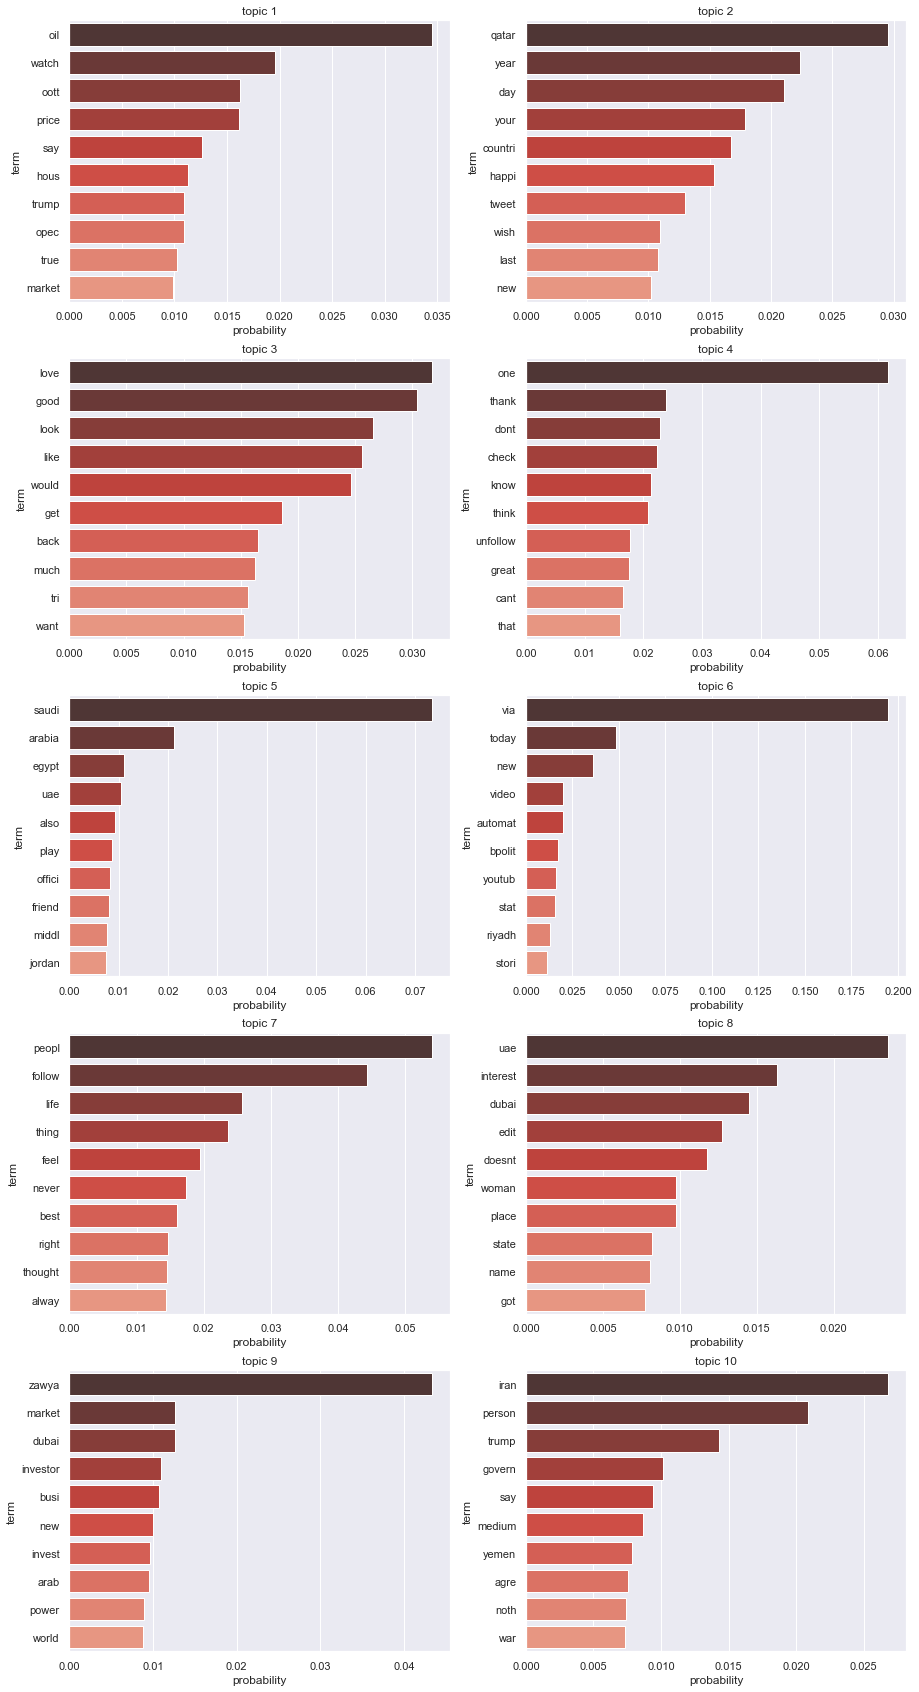

In [313]:
fiz=plt.figure(figsize=(15,30))
for i in range(10):
    df=pd.DataFrame(ldamodelf.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
    

plt.show()

In [51]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=ldamodelf, texts=ff.tweet.values, dictionary=dictionaryf, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3091985947502065


In [315]:
from wordcloud import WordCloud

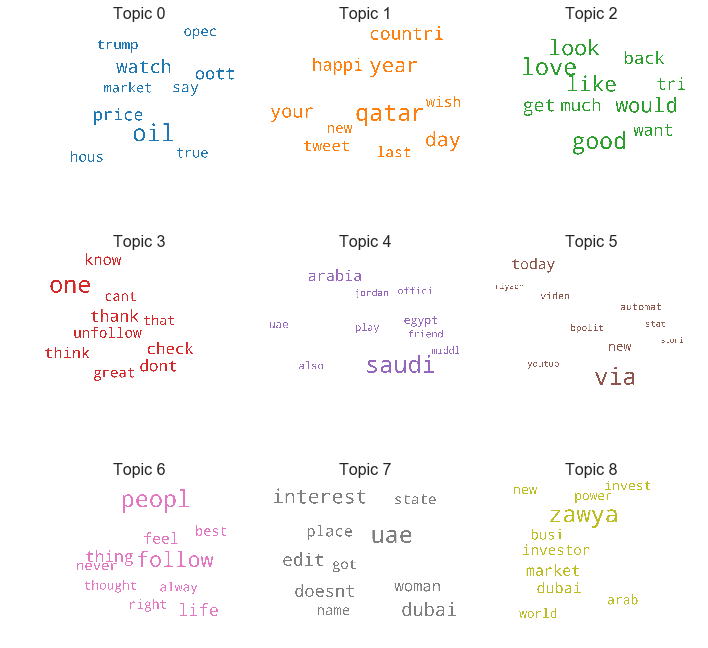

In [323]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodelf.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [52]:
dictionary = corpora.Dictionary(af.tweet.values)
corpus = [dictionary.doc2bow(text) for text in af.tweet.values]
len(corpus[0])

1051

In [53]:
ldamodel = models.ldamodel.LdaModel(corpus,
                                    id2word = dictionary, # connect each word to its "spot" in the dictionary
                                    num_topics = 10, # hyperparameter T for number of topics
                                    passes = 5, # similar to epochs, how many times do we iterate through the data untel convergence accures
                                    minimum_probability = 0.01) # only including topics that meet some probability threshold

In [54]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/LujFel/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.044211 -0.022576       1        1  37.591194
6     -0.052095 -0.062442       2        1  20.745152
4     -0.013472 -0.059518       3        1  14.483274
5     -0.051376  0.050427       4        1   5.864991
0     -0.031207 -0.033320       5        1   5.819741
3      0.058572  0.021214       6        1   3.907130
7     -0.080048  0.078349       7        1   3.755738
2      0.084802 -0.012968       8        1   3.222817
9     -0.011357 -0.039493       9        1   2.701452
8      0.051970  0.080328      10        1   1.908519, topic_info=       Category          Freq      Term         Total  loglift  logprob
term                                                                   
4694    Default  25889.000000       via  25889.000000  30.0000  30.0000
2354    Default   9474.000000    follow   9474.000000  29.0000  29.0000
635     Default  16366.000000       one  16366.000000  28.0000  28.0000
145     Default   6992.000000     check   6992.000000  27.0000  27.0000
664     Default  11567.000000     peopl  11567.000000  26.0000  26.0000
1268    Default   3696.000000   automat   3696.000000  25.0000  25.0000
667     Default   5265.000000    person   5265.000000  24.0000  24.0000
12979   Default   3430.000000  unfollow   3430.000000  23.0000  23.0000
614     Default  13256.000000       new  13256.000000  22.0000  22.0000
631     Default   9687.000000       oil   9687.000000  21.0000  21.0000
2803    Default   2977.000000  investor   2977.000000  20.0000  20.0000
25859   Default   6269.000000      oott   6269.000000  19.0000  19.0000
938     Default   7427.000000     today   7427.000000  18.0000  18.0000
518     Default   7789.000000      love   7789.000000  17.0000  17.0000
445     Default   2764.000000       ive   2764.000000  16.0000  16.0000
1034    Default   8228.000000     would   8228.000000  15.0000  15.0000
992     Default   3835.000000     video   3835.000000  14.0000  14.0000
1005    Default   4701.000000     watch   4701.000000  13.0000  13.0000
470     Default   8481.000000      know   8481.000000  12.0000  12.0000
919     Default  10221.000000     thank  10221.000000  11.0000  11.0000
4886    Default   3183.000000    youtub   3183.000000  10.0000  10.0000
350     Default  10305.000000      good  10305.000000   9.0000   9.0000
134005  Default   1703.000000      swfi   1703.000000   8.0000   8.0000
499     Default  12260.000000      like  12260.000000   7.0000   7.0000
968     Default   4834.000000       uae   4834.000000   6.0000   6.0000
4548    Default   4902.000000     trump   4902.000000   5.0000   5.0000
7229    Default   2176.000000  pakistan   2176.000000   4.0000   4.0000
867     Default   4194.000000     stori   4194.000000   3.0000   3.0000
345     Default  11509.000000       get  11509.000000   2.0000   2.0000
897     Default   2066.000000   sustain   2066.000000   1.0000   1.0000
...         ...           ...       ...           ...      ...      ...
12479   Topic10     74.824928     quest    133.249985   3.3818  -6.6776
5058    Topic10    450.379059    episod   1187.701782   2.9892  -4.8827
59848   Topic10     79.805527   jimcram    150.639832   3.3235  -6.6132
26449   Topic10     35.556118    gotham     56.327469   3.4988  -7.4217
445     Topic10    750.226746       ive   2764.505127   2.6546  -4.3724
3974    Topic10     25.289827      scmp     37.425613   3.5669  -7.7624
134141  Topic10     34.623795   cramerq     56.750671   3.4647  -7.4482
134212  Topic10     24.557449  jackmohr     36.391159   3.5655  -7.7918
4694    Topic10   2560.793945       via  25889.511719   1.6453  -3.1447
8713    Topic10     80.535873       dan    233.015030   2.8964  -6.6041
2505    Topic10    157.112503      gold    680.396912   2.4931  -5.9358
2356    Topic10    336.461609      food   2280.008301   2.0454  -5.1743
1005    Topic10    507.670471     watch   4701.562012   1.7330  -4.76

In [55]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=af.tweet.values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.319282137256176


# Features Extraction

In [82]:
ff.head()

,id,date,time,username,tweet,mentions,hashtags
0,1.045203e+18,2018-09-27,06:47:22,10mgp,"[sure, luci, couldnt, miss, see, speak, line, ...","['lucylucyprior', 'xrailgroup', 'transcityrail']",NaN
1,1.036687e+18,2018-09-03,18:48:27,10mgp,"[darbaarbyabdul, guy, close, tri, phone, guy, ...",['darbaarbyabdul'],NaN
2,1.028857e+18,2018-08-13,04:15:16,10mgp,"[british, airway, safeti, lucki, serv, tea]","['johnmsv', 'emirates', 'british_airways']",NaN
3,1.017129e+18,2018-07-11,19:30:04,10mgp,"[ive, enter, autotradergo, chanc, win, free, car]",NaN,['#autotradergoals']
4,1.013736e+18,2018-07-02,10:45:58,10mgp,"[becci, sent, ongo, issu, thank]",['landrover_uk'],NaN


In [87]:
ff['topics'] = ff['tweet'].progress_apply(lambda x: dict((ldamodelf.get_document_topics([dictionaryf.doc2bow(x)], minimum_probability=None)[0])))

In [88]:
ff.head()

,id,date,time,username,tweet,mentions,hashtags,topics,0,1,2,3,4,5,6,7,8,9
0,1.045203e+18,2018-09-27,06:47:22,10mgp,"[sure, luci, couldnt, miss, see, speak, line, ...","['lucylucyprior', 'xrailgroup', 'transcityrail']",NaN,"{0: 0.0100580305, 1: 0.0100580305, 2: 0.228744...",0.010017,0.010017,0.010015,0.010016,0.010018,0.010016,0.909852,0.010016,0.010015,0.010017
1,1.036687e+18,2018-09-03,18:48:27,10mgp,"[darbaarbyabdul, guy, close, tri, phone, guy, ...",['darbaarbyabdul'],NaN,"{1: 0.12951413, 2: 0.30384994, 8: 0.50829476}",0.270242,0.000000,0.000000,0.000000,0.000000,0.000000,0.663062,0.000000,0.000000,0.000000
2,1.028857e+18,2018-08-13,04:15:16,10mgp,"[british, airway, safeti, lucki, serv, tea]","['johnmsv', 'emirates', 'british_airways']",NaN,"{0: 0.15713021, 1: 0.15714662, 2: 0.014292412,...",0.584856,0.014309,0.014313,0.014306,0.014308,0.014308,0.014309,0.300673,0.014309,0.014309
3,1.017129e+18,2018-07-11,19:30:04,10mgp,"[ive, enter, autotradergo, chanc, win, free, car]",NaN,['#autotradergoals'],"{0: 0.15712872, 1: 0.15715624, 2: 0.014287142,...",0.012632,0.012632,0.012632,0.012633,0.012634,0.012637,0.012633,0.012633,0.439998,0.458936
4,1.013736e+18,2018-07-02,10:45:58,10mgp,"[becci, sent, ongo, issu, thank]",['landrover_uk'],NaN,"{0: 0.020004185, 1: 0.21999583, 2: 0.020004185...",0.016796,0.016799,0.016795,0.016797,0.016796,0.016794,0.016796,0.016794,0.016794,0.848840


In [89]:
def khal(x, a):
    try:
        b = x[a]
    except :
        b = 0 
    return b

In [90]:
A = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for a in A:
    ff[str(a)] = ff['topics'].progress_apply(lambda x: khal(x, a))

In [91]:
ff.head()

,id,date,time,username,tweet,mentions,hashtags,topics,0,1,2,3,4,5,6,7,8,9
0,1.045203e+18,2018-09-27,06:47:22,10mgp,"[sure, luci, couldnt, miss, see, speak, line, ...","['lucylucyprior', 'xrailgroup', 'transcityrail']",NaN,"{0: 0.0100580305, 1: 0.0100580305, 2: 0.228744...",0.010058,0.010058,0.228744,0.487173,0.113148,0.010058,0.010058,0.010058,0.010060,0.110585
1,1.036687e+18,2018-09-03,18:48:27,10mgp,"[darbaarbyabdul, guy, close, tri, phone, guy, ...",['darbaarbyabdul'],NaN,"{1: 0.12951413, 2: 0.30384994, 8: 0.50829476}",0.000000,0.129514,0.303850,0.000000,0.000000,0.000000,0.000000,0.000000,0.508295,0.000000
2,1.028857e+18,2018-08-13,04:15:16,10mgp,"[british, airway, safeti, lucki, serv, tea]","['johnmsv', 'emirates', 'british_airways']",NaN,"{0: 0.15713021, 1: 0.15714662, 2: 0.014292412,...",0.157130,0.157147,0.014292,0.014292,0.157099,0.157097,0.014292,0.300065,0.014292,0.014292
3,1.017129e+18,2018-07-11,19:30:04,10mgp,"[ive, enter, autotradergo, chanc, win, free, car]",NaN,['#autotradergoals'],"{0: 0.15712872, 1: 0.15715624, 2: 0.014287142,...",0.157129,0.157156,0.014287,0.014288,0.299989,0.014289,0.157153,0.157131,0.014290,0.014287
4,1.013736e+18,2018-07-02,10:45:58,10mgp,"[becci, sent, ongo, issu, thank]",['landrover_uk'],NaN,"{0: 0.020004185, 1: 0.21999583, 2: 0.020004185...",0.020004,0.219996,0.020004,0.419946,0.020008,0.020004,0.020004,0.020004,0.020007,0.220022


In [92]:
from textblob import TextBlob

In [93]:
TextBlob("I hate this").sentiment.polarity

-0.8

In [94]:
gf = pd.read_csv('finale_go_clean.csv')

In [98]:
ff['sentiment'] = gf['tweet'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)

In [99]:
ff.head()

,id,date,time,username,tweet,mentions,hashtags,topics,0,1,2,3,4,5,6,7,8,9,sentiment
0,1.045203e+18,2018-09-27,06:47:22,10mgp,"[sure, luci, couldnt, miss, see, speak, line, ...","['lucylucyprior', 'xrailgroup', 'transcityrail']",NaN,"{0: 0.0100580305, 1: 0.0100580305, 2: 0.228744...",0.010058,0.010058,0.228744,0.487173,0.113148,0.010058,0.010058,0.010058,0.010060,0.110585,0.500000
1,1.036687e+18,2018-09-03,18:48:27,10mgp,"[darbaarbyabdul, guy, close, tri, phone, guy, ...",['darbaarbyabdul'],NaN,"{1: 0.12951413, 2: 0.30384994, 8: 0.50829476}",0.000000,0.129514,0.303850,0.000000,0.000000,0.000000,0.000000,0.000000,0.508295,0.000000,-0.085185
2,1.028857e+18,2018-08-13,04:15:16,10mgp,"[british, airway, safeti, lucki, serv, tea]","['johnmsv', 'emirates', 'british_airways']",NaN,"{0: 0.15713021, 1: 0.15714662, 2: 0.014292412,...",0.157130,0.157147,0.014292,0.014292,0.157099,0.157097,0.014292,0.300065,0.014292,0.014292,0.333333
3,1.017129e+18,2018-07-11,19:30:04,10mgp,"[ive, enter, autotradergo, chanc, win, free, car]",NaN,['#autotradergoals'],"{0: 0.15712872, 1: 0.15715624, 2: 0.014287142,...",0.157129,0.157156,0.014287,0.014288,0.299989,0.014289,0.157153,0.157131,0.014290,0.014287,0.600000
4,1.013736e+18,2018-07-02,10:45:58,10mgp,"[becci, sent, ongo, issu, thank]",['landrover_uk'],NaN,"{0: 0.020004185, 1: 0.21999583, 2: 0.020004185...",0.020004,0.219996,0.020004,0.419946,0.020008,0.020004,0.020004,0.020004,0.020007,0.220022,0.000000


In [124]:
ff['Timestamp'] = pd.to_datetime(ff['date'] + ' ' + ff['time'])

In [135]:
ff['DayOfWeek'] = ff['Timestamp'].progress_apply(lambda x: x.dayofweek)

In [136]:
ff['Month'] = ff['Timestamp'].progress_apply(lambda x: x.month)

In [138]:
ff['Hour'] = ff['Timestamp'].progress_apply(lambda x: x.hour)

In [139]:
ff.head()

,id,date,time,username,tweet,mentions,hashtags,topics,0,1,...,5,6,7,8,9,sentiment,Timestamp,DayOfWeek,Month,Hour
0,1.045203e+18,2018-09-27,06:47:22,10mgp,"[sure, luci, couldnt, miss, see, speak, line, ...","['lucylucyprior', 'xrailgroup', 'transcityrail']",NaN,"{0: 0.0100580305, 1: 0.0100580305, 2: 0.228744...",0.010058,0.010058,...,0.010058,0.010058,0.010058,0.010060,0.110585,0.500000,2018-09-27 06:47:22,3,9,6
1,1.036687e+18,2018-09-03,18:48:27,10mgp,"[darbaarbyabdul, guy, close, tri, phone, guy, ...",['darbaarbyabdul'],NaN,"{1: 0.12951413, 2: 0.30384994, 8: 0.50829476}",0.000000,0.129514,...,0.000000,0.000000,0.000000,0.508295,0.000000,-0.085185,2018-09-03 18:48:27,0,9,18
2,1.028857e+18,2018-08-13,04:15:16,10mgp,"[british, airway, safeti, lucki, serv, tea]","['johnmsv', 'emirates', 'british_airways']",NaN,"{0: 0.15713021, 1: 0.15714662, 2: 0.014292412,...",0.157130,0.157147,...,0.157097,0.014292,0.300065,0.014292,0.014292,0.333333,2018-08-13 04:15:16,0,8,4
3,1.017129e+18,2018-07-11,19:30:04,10mgp,"[ive, enter, autotradergo, chanc, win, free, car]",NaN,['#autotradergoals'],"{0: 0.15712872, 1: 0.15715624, 2: 0.014287142,...",0.157129,0.157156,...,0.014289,0.157153,0.157131,0.014290,0.014287,0.600000,2018-07-11 19:30:04,2,7,19
4,1.013736e+18,2018-07-02,10:45:58,10mgp,"[becci, sent, ongo, issu, thank]",['landrover_uk'],NaN,"{0: 0.020004185, 1: 0.21999583, 2: 0.020004185...",0.020004,0.219996,...,0.020004,0.020004,0.020004,0.020007,0.220022,0.000000,2018-07-02 10:45:58,0,7,10


In [142]:
mf = ff[['id', 'username', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'DayOfWeek', 'Month', 'Hour', 'sentiment']]

In [143]:
mf.head()

,id,username,0,1,2,3,4,5,6,7,8,9,DayOfWeek,Month,Hour,sentiment
0,1.045203e+18,10mgp,0.010058,0.010058,0.228744,0.487173,0.113148,0.010058,0.010058,0.010058,0.010060,0.110585,3,9,6,0.500000
1,1.036687e+18,10mgp,0.000000,0.129514,0.303850,0.000000,0.000000,0.000000,0.000000,0.000000,0.508295,0.000000,0,9,18,-0.085185
2,1.028857e+18,10mgp,0.157130,0.157147,0.014292,0.014292,0.157099,0.157097,0.014292,0.300065,0.014292,0.014292,0,8,4,0.333333
3,1.017129e+18,10mgp,0.157129,0.157156,0.014287,0.014288,0.299989,0.014289,0.157153,0.157131,0.014290,0.014287,2,7,19,0.600000
4,1.013736e+18,10mgp,0.020004,0.219996,0.020004,0.419946,0.020008,0.020004,0.020004,0.020004,0.020007,0.220022,0,7,10,0.000000


In [144]:
mf.sentiment.describe()

count    376949.000000
mean          0.109049
std           0.288200
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.250000
max           1.000000
Name: sentiment, dtype: float64

/Users/LujFel/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/Users/LujFel/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


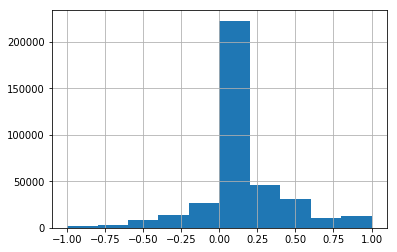

In [146]:
mf.sentiment.hist()